# Generic dfs processing
Tools and methods that applies to any type of dfs files. 

The generic tools are useful for common data processing tasks, where detailed configuration is not necessary. 

mikeio.generic: methods that read any dfs file and outputs a new dfs file of the same type

- concat: Concatenates files along the time axis  
- scale: Apply scaling to any dfs file
- sum: Sum two dfs files 
- diff: Calculate difference between two dfs files
- extract: Extract timesteps and/or items to a new dfs file
- time-avg: Create a temporally averaged dfs file
- quantile: Create temporal quantiles of dfs file

The generic methods works on larger-than-memory files as they process one time step at a time. This can however make them in-efficient for dfs0 processing! 

See [Generic in MIKE IO Documentation](https://dhi.github.io/mikeio/generic.html)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mikeio
import mikeio.generic

## Concatenation

Take a look at these two files with overlapping timesteps.

In [2]:
t1 = mikeio.read("data/tide1.dfs1")
t1

<mikeio.Dataset>
dims: (time:97, x:10)
time: 2019-01-01 00:00:00 - 2019-01-03 00:00:00 (97 records)
geometry: Grid1D (n=10, dx=0.06667)
items:
  0:  Level <Water Level> (meter)

In [3]:
t2 = mikeio.read("data/tide2.dfs1")
t2

<mikeio.Dataset>
dims: (time:97, x:10)
time: 2019-01-02 00:00:00 - 2019-01-04 00:00:00 (97 records)
geometry: Grid1D (n=10, dx=0.06667)
items:
  0:  Level <Water Level> (meter)

Plot one of the points along the line.

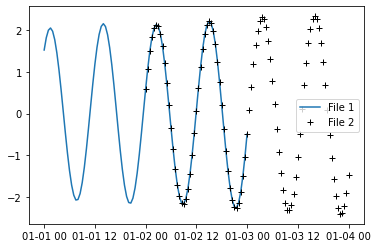

In [4]:
plt.plot(t1.time,t1[0].isel(x=1).values, label="File 1")
plt.plot(t2.time,t2[0].isel(x=1).values,'k+', label="File 2")
plt.legend()

In [5]:
mikeio.generic.concat(infilenames=["data/tide1.dfs1",
                                   "data/tide2.dfs1"],
                      outfilename="concat.dfs1", keep="last")

<mikeio.Dataset>
dims: (time:145, x:10)
time: 2019-01-01 00:00:00 - 2019-01-04 00:00:00 (145 records)
geometry: Grid1D (n=10, dx=0.06667)
items:
  0:  Level <Water Level> (meter)

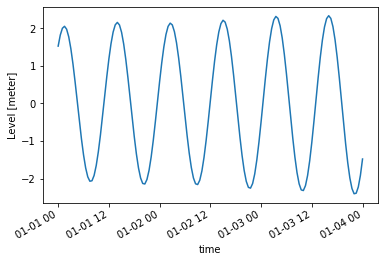

In [6]:
c = mikeio.read("concat.dfs1")
c[0].isel(x=1).plot()
c

## Extract time steps or items

The extract() method can extract a part of a file:

* **time slice** by specifying *start* and/or *end*
* specific **items**

In [7]:
infile = "data/tide1.dfs1"
mikeio.generic.extract(infile, "extracted.dfs1", start='2019-01-02')

In [8]:
e = mikeio.read("extracted.dfs1")
e

<mikeio.Dataset>
dims: (time:49, x:10)
time: 2019-01-02 00:00:00 - 2019-01-03 00:00:00 (49 records)
geometry: Grid1D (n=10, dx=0.06667)
items:
  0:  Level <Water Level> (meter)

In [9]:
infile = "data/oresund_vertical_slice.dfsu"
mikeio.generic.extract(infile, "extracted.dfsu", items='Salinity', end=-2)

In [10]:
e = mikeio.read("extracted.dfsu")
e

<mikeio.Dataset>
dims: (time:2, element:441)
time: 1997-09-15 21:00:00 - 1997-09-16 00:00:00 (2 records)
geometry: DfsuVerticalProfileSigmaZ (441 elements, 4 sigma-layers, 5 z-layers)
items:
  0:  Salinity <Salinity> (PSU)

## Diff

Take difference between two dfs files with same structure - e.g. to see the difference in result between two calibration runs

In [11]:
fn1 = "data/oresundHD_run1.dfsu"
fn2 = "data/oresundHD_run2.dfsu"
fn_diff = "oresundHD_difference.dfsu"
mikeio.generic.diff(fn1, fn2, fn_diff)

100%|██████████| 5/5 [00:00<?, ?it/s]


Let's open the files and visualize the last time step of the first item (water level)

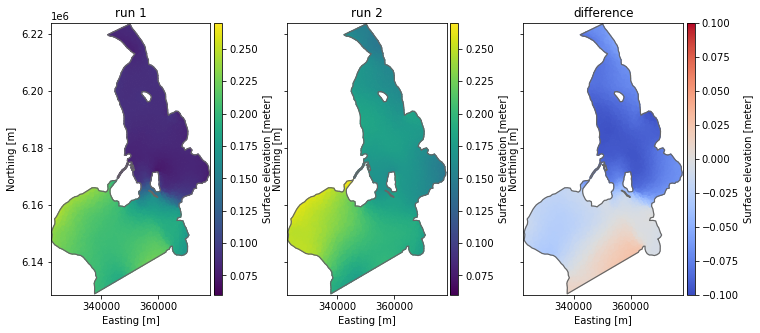

In [12]:
_, ax = plt.subplots(1,3, sharey=True, figsize=(12,5))
da = mikeio.read(fn1, time=-1)[0]
da.plot(vmin=0.06, vmax=0.27, ax=ax[0], title='run 1')
da = mikeio.read(fn2, time=-1)[0]
da.plot(vmin=0.06, vmax=0.27, ax=ax[1], title='run 2')
da = mikeio.read(fn_diff, time=-1)[0]
da.plot(vmin=-0.1, vmax=0.1, cmap='coolwarm', ax=ax[2], title='difference');

## Scaling

Adding a constant e.g to adjust datum

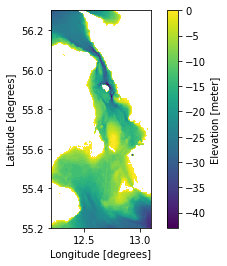

In [13]:
ds = mikeio.read("data/gebco_sound.dfs2")
ds.Elevation.plot();

In [14]:
ds['Elevation'][0,104,131]

<mikeio.DataArray>
name: Elevation
dims: ()
time: 2020-05-15 11:04:52 (time-invariant)
geometry: GeometryPoint2D(x=12.74791669513408, y=55.63541668926675)
values: -1.0

This is the processing step.

In [15]:
mikeio.generic.scale("data/gebco_sound.dfs2","gebco_sound_local_datum.dfs2",offset=-2.1)

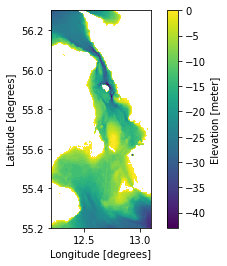

In [16]:
ds2 = mikeio.read("gebco_sound_local_datum.dfs2")
ds.Elevation.plot();

In [17]:
ds2['Elevation'][0,104,131]

<mikeio.DataArray>
name: Elevation
dims: ()
time: 2020-05-15 11:04:52 (time-invariant)
geometry: GeometryPoint2D(x=12.74791669513408, y=55.63541668926675)
values: -3.0999999046325684

### Spatially varying correction

In [18]:
import numpy as np
factor = np.ones_like(ds['Elevation'][0].to_numpy())
factor.shape

(264, 216)

Add some spatially varying factors, exaggerated values for educational purpose.

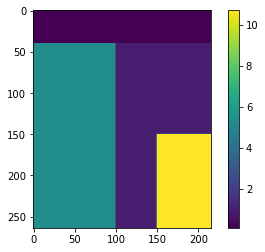

In [19]:
factor[:,0:100] = 5.3
factor[0:40,] = 0.1
factor[150:,150:] = 10.7
plt.imshow(factor)
plt.colorbar();

The 2d array must first be flipped upside down and then converted to a 1d vector using [numpy.ndarray.flatten](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html) to match how data is stored in dfs files.

In [20]:
factor_ud = np.flipud(factor)
factor_vec  = factor_ud.flatten()
mikeio.generic.scale("data/gebco_sound.dfs2","gebco_sound_spatial.dfs2",factor=factor_vec)

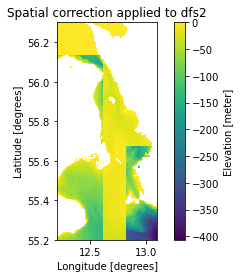

In [21]:
ds3 = mikeio.read("gebco_sound_spatial.dfs2")
ds3.Elevation.plot()
plt.title("Spatial correction applied to dfs2");

## Clean up

In [22]:
import os
os.remove("concat.dfs1")
os.remove("extracted.dfs1")
os.remove("extracted.dfsu")
os.remove("oresundHD_difference.dfsu")
os.remove("gebco_sound_local_datum.dfs2")
os.remove("gebco_sound_spatial.dfs2")